In [4]:
import urllib.request
import os
import tarfile
# 下载cifar数据集
url = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
filepath = 'data/cifar-10-python.tar.gz'
if not os.path.isfile(filepath):
    result = urllib.request.urlretrieve(url, filepath)
    print('download:', result)
else:
    print('Data file already exists.')
#  解压
if not os.path.exists("data/cifar-10-batches-py"):
    tfile = tarfile.open("data/cifar-10-python.tar.gz", 'r:gz')
    result = tfile.extractall('data/')
    print('Extracted to ./data/cifar-10-batches-py/')
else:
    print('Directory already exists.')

Data file already exists.
Directory already exists.


In [8]:
import pickle as p
import numpy as np
# 导入CIFAR数据集
def load_CIFAR_batch(filename):
    with open(filename, 'rb') as f:
        data_dict = p.load(f, encoding = 'bytes')
        images = data_dict[b'data']
        labels = data_dict[b'labels']
        images = images.reshape(10000, 3, 32, 32)
        images = images.transpose(0,2,3,1)
        labels = np.array(labels)
        return images, labels
def load_CIFAR_data(data_dir):
    images_train=[]
    labels_train=[]
    for i in range(5):
        f=os.path.join(data_dir, 'data_batch_%d' % (i+1))
        print('loading', f)
        image_batch, label_batch = load_CIFAR_batch(f)
        images_train.append(image_batch)
        labels_train.append(label_batch)
        Xtrain = np.concatenate(images_train)
        Ytrain = np.concatenate(labels_train)
        del image_batch, label_batch
    Xtest, Ytest = load_CIFAR_batch(os.path.join(data_dir, 'test_batch'))
    print('finished loadding CIFAR-10 data')
    return Xtrain, Ytrain, Xtest, Ytest

data_dir = 'data/cifar-10-batches-py'
Xtrain, Ytrain, Xtest, Ytest = load_CIFAR_data(data_dir)
# 显示数据集信息
print('training data shape:', Xtrain.shape)
print('training labels shape:', Ytrain.shape)
print('test data shape:', Xtest.shape)
print('test labels shape:', Ytest.shape)

loading data/cifar-10-batches-py\data_batch_1
loading data/cifar-10-batches-py\data_batch_2
loading data/cifar-10-batches-py\data_batch_3
loading data/cifar-10-batches-py\data_batch_4
loading data/cifar-10-batches-py\data_batch_5
finished loadding CIFAR-10 data
training data shape: (50000, 32, 32, 3)
training labels shape: (50000,)
test data shape: (10000, 32, 32, 3)
test labels shape: (10000,)


2


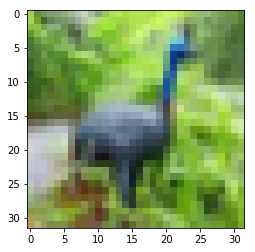

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(Xtrain[6])
print(Ytrain[6])

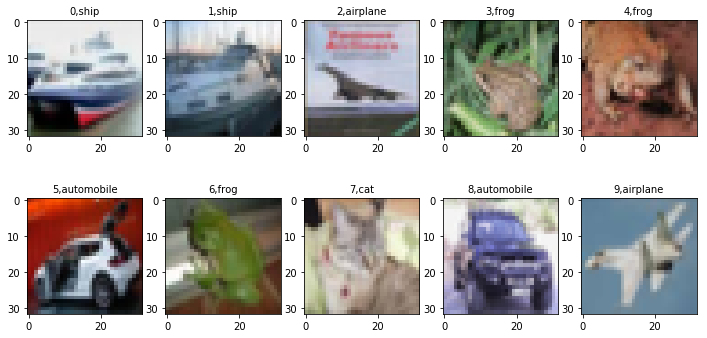

In [11]:
label_dict = {0:"airplane", 1:"automobile", 2:"bird", 3:"cat", 4:"deer", 5:"dog", 6:"frog", 7:"horse", 8:"ship", 9:"truck"}
# 定义显示图像数据及其对应标签的函数
def plot_images_labels_prediction(images, labels, prediction, idx, num=10):
    fig = plt.gcf()
    fig.set_size_inches(12,6)
    if num>10:
        num = 10
    for i in range(0, num):
        ax = plt.subplot(2, 5, 1+i)
        ax.imshow(images[idx], cmap='binary')
        title=str(i)+','+label_dict[labels[idx]]
        if len(prediction) > 0:
            title += '=>' + label_dict[prediction[idx]]
        ax.set_title(title, fontsize=10)
        idx+=1
    plt.show()
plot_images_labels_prediction(Xtest, Ytest, [], 1, 10)

In [14]:
# 图像数据预处理
# 显示第一个图的第一个像素点
Xtrain[0][0][0]
# 将图像进行数字标准化
Xtrain_normalize = Xtrain.astype('float32')/255.0
Xtest_normalize = Xtest.astype('float32')/255.0
# 查看预处理后图像数据信息
Xtrain_normalize[0][0][0]

array([0.23137255, 0.24313726, 0.24705882], dtype=float32)

In [17]:
# 标签数据预处理：独热编码
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False)
yy = [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9]]
encoder.fit(yy)
Ytrain_reshape = Ytrain.reshape(-1, 1)
Ytrain_onehot = encoder.transform(Ytrain_reshape)
Ytest_reshape = Ytest.reshape(-1, 1)
Ytest_onehot = encoder.transform(Ytest_reshape)
Ytrain[:5]
Ytrain_onehot[:5]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
# 定义共享函数
# 定义权值
def weight(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.1), name='W')
# 定义偏置
def bias(shape):
    return tf.Variable(tf.constant(0.1, shape=shape), name='b')
# 定义卷积操作
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME')
# 定义池化操作
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], padding='SAME')